In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from src.names import *
from src.visual import *
from src.dumping_loading import *

plt.rcParams['font.size'] = 12
plt.rcParams['savefig.format'] = 'pdf'
np.random.seed(seed=42)

from typing import Optional, Union

import numpy as np
import pandas as pd

import seaborn as sns # for better visual aesthetics
sns.set_theme(style='white', context='paper')
%config InlineBackend.figure_format = "svg"

import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.size'] = 12
plt.rcParams['savefig.format'] = 'pdf'
sns.set_style('darkgrid')

from polara import get_movielens_data
from src.splits import *
from src.utils import *
from src.algorithms import *
from src.visual import *
from src.testing import *
from src.names import *

import datetime
import dateutil.relativedelta

# Data prep

In [7]:
data_, genres_info = get_movielens_data(
    get_genres=True, # get genre information in addition to ratings
    split_genres=False,
    include_time=True
)
data_['timestamp'] = pd.to_datetime(data_['timestamp'], unit='s')
data_ = data_.sort_values('timestamp')

data_.reset_index(inplace=True, drop=True)
data = delete_low_and_binarize(data_)
print(data.shape)
data.head()

(575281, 4)


,userid,movieid,rating,timestamp
0,6040,858,1,2000-04-25 23:05:32
1,6040,2384,1,2000-04-25 23:05:54
2,6040,593,1,2000-04-25 23:05:54
3,6040,1961,1,2000-04-25 23:06:17
4,6040,2019,1,2000-04-25 23:06:17


In [8]:
# split_type = 3
clean_data = data

# делаем сквозные возрастающие айди для пользователей
global_mapping_userid = update_mapping(clean_data, 'userid')
apply_mapping(clean_data, global_mapping_userid, 'userid')
# делаем сквозные возрастающие айди для айтемов
global_mapping_movieid = update_mapping(clean_data, 'movieid')
apply_mapping(clean_data, global_mapping_movieid, 'movieid')

checkpoint_train_val = int(len(data) * 0.5)
checkpoint_val_test = int(len(data) * 0.75)
trainingdata, valdata, testdata = (
    clean_data[:checkpoint_train_val], 
    data[checkpoint_train_val:checkpoint_val_test],  
    data[checkpoint_val_test:]
)

print(f"trainingdata.shape: {trainingdata.shape}")
print(f"valdata.shape: {valdata.shape}")
print(f"testdata.shape: {testdata.shape}")
print(f"trainingdata %: {(trainingdata.shape[0]/data.shape[0]) * 100}%")
print(f"valdata %: {(valdata.shape[0]/data.shape[0]) * 100}%")
print(f"testdata %: {(testdata.shape[0]/data.shape[0]) * 100}%")

trainingdata.shape: (287640, 4)
valdata.shape: (143820, 4)
testdata.shape: (143821, 4)
trainingdata %: 49.99991308595278%
valdata %: 24.99995654297639%
testdata %: 25.000130371070835%


In [ ]:
calibration_data = prepare_split(
    training=trainingdata, 
    holdout=valdata, 
    n_periods=5, 
    flag_virtual=True, 
    periods_split_type=INTERACTION_SPLIT, 
    n_active_users_in_period=None
)

In [ ]:
bigtraindata = pd.concat([trainingdata, valdata])

measure_data = prepare_split(
    training=bigtraindata, 
    holdout=testdata,
    n_periods=5,
    flag_virtual=True, 
    periods_split_type=INTERACTION_SPLIT, 
    n_active_users_in_period=None
)

In [12]:
import pickle

folder_name = 'experiment_data'
data_fname = '50-25-25-virtual-interactions'

# data_fname = '8periods-8month-0-virtual-interactions'
# with open(f'positive_data/{data_fname}', 'rb') as f:
#     data = pickle.load(f)

with open(f'{folder_name}/{data_fname}_trainval', 'wb') as f:
    pickle.dump(calibration_data, f)
with open(f'{folder_name}/{data_fname}_traintest', 'wb') as f:
    pickle.dump(measure_data, f)

# Подбор параметров

Метрики:
* hitrate (кумулятивная за все периоды, не считая изначального разложения)
* MRR (кумулятивная за все периоды, не считая изначального разложения)
* coverage (средняя за все периоды, не считая изначального разложения)
* stability (средняя за все периоды, не считая изначального разложения)

Параметры:
* SVD, Rand SVD, Reused projector: ранг
* PSI 1-st order / PSI 2-nd order: ранг, порядок обновлений

In [17]:
ranks = [10, 20, 30, 40, 50, 60, 70, 80]
types_of_update = [USERS_FIRST, ITEMS_FIRST]
K = 10

In [19]:
experiment_metrics_dict = {}
for alg_name in [SVD, RAND_SVD, REUSED_PROJECTOR_INCREMENTAL]:
    experiment_metrics_dict[alg_name] = {}
    for rank in ranks:
        print(rank)
        metrics = metrics_experiment(
            algorithm_name=alg_name,
            rank=rank,
            K=K,
            update_type=None,
            training=trainingdata,
            data=calibration_data
        )
        experiment_metrics_dict[alg_name][rank] = metrics

10


svd: 100%|██████████| 6/6 [00:10<00:00,  1.71s/it]


20


svd: 100%|██████████| 6/6 [00:11<00:00,  1.97s/it]


30


svd: 100%|██████████| 6/6 [00:15<00:00,  2.53s/it]


40


svd: 100%|██████████| 6/6 [00:16<00:00,  2.81s/it]


50


svd: 100%|██████████| 6/6 [00:15<00:00,  2.65s/it]


60


svd: 100%|██████████| 6/6 [00:18<00:00,  3.13s/it]


70


svd: 100%|██████████| 6/6 [00:18<00:00,  3.13s/it]


80


svd: 100%|██████████| 6/6 [00:22<00:00,  3.70s/it]


10


rand svd: 100%|██████████| 6/6 [00:09<00:00,  1.63s/it]


20


rand svd: 100%|██████████| 6/6 [00:09<00:00,  1.64s/it]


30


rand svd: 100%|██████████| 6/6 [00:09<00:00,  1.54s/it]


40


rand svd: 100%|██████████| 6/6 [00:09<00:00,  1.59s/it]


50


rand svd: 100%|██████████| 6/6 [00:10<00:00,  1.70s/it]


60


rand svd: 100%|██████████| 6/6 [00:09<00:00,  1.62s/it]


70


rand svd: 100%|██████████| 6/6 [00:10<00:00,  1.68s/it]


80


rand svd: 100%|██████████| 6/6 [00:10<00:00,  1.68s/it]


10


reused projector (incremental): 100%|██████████| 6/6 [00:11<00:00,  1.92s/it]


20


reused projector (incremental): 100%|██████████| 6/6 [00:11<00:00,  2.00s/it]


30


reused projector (incremental): 100%|██████████| 6/6 [00:11<00:00,  1.99s/it]


40


reused projector (incremental): 100%|██████████| 6/6 [00:12<00:00,  2.10s/it]


50


reused projector (incremental): 100%|██████████| 6/6 [00:12<00:00,  2.15s/it]


60


reused projector (incremental): 100%|██████████| 6/6 [00:12<00:00,  2.02s/it]


70


reused projector (incremental): 100%|██████████| 6/6 [00:13<00:00,  2.20s/it]


80


reused projector (incremental): 100%|██████████| 6/6 [00:12<00:00,  2.14s/it]


In [20]:
experiment_metrics_dict_psi = {}
for alg_name in [PSI1, PSI2]:
    experiment_metrics_dict_psi[alg_name] = {}
    for update_type in types_of_update:
        print(update_type)
        experiment_metrics_dict_psi[alg_name][update_type] = {}
        for rank in ranks:
            print(rank)
            metrics = metrics_experiment(
                algorithm_name=alg_name,
                rank=rank,
                K=K,
                update_type=update_type,
                training=trainingdata,
                data=calibration_data
            )
            experiment_metrics_dict_psi[alg_name][update_type][rank] = metrics

users first
10


psi 1 order: 100%|██████████| 6/6 [00:12<00:00,  2.15s/it]


20


psi 1 order: 100%|██████████| 6/6 [00:12<00:00,  2.16s/it]


30


psi 1 order: 100%|██████████| 6/6 [00:13<00:00,  2.19s/it]


40


psi 1 order: 100%|██████████| 6/6 [00:13<00:00,  2.24s/it]


50


psi 1 order: 100%|██████████| 6/6 [00:14<00:00,  2.37s/it]


60


psi 1 order: 100%|██████████| 6/6 [00:14<00:00,  2.38s/it]


70


psi 1 order: 100%|██████████| 6/6 [00:14<00:00,  2.43s/it]


80


psi 1 order: 100%|██████████| 6/6 [00:15<00:00,  2.52s/it]


items first
10


psi 1 order: 100%|██████████| 6/6 [00:12<00:00,  2.13s/it]


20


psi 1 order: 100%|██████████| 6/6 [00:12<00:00,  2.15s/it]


30


psi 1 order: 100%|██████████| 6/6 [00:13<00:00,  2.20s/it]


40


psi 1 order: 100%|██████████| 6/6 [00:13<00:00,  2.22s/it]


50


psi 1 order: 100%|██████████| 6/6 [00:13<00:00,  2.29s/it]


60


psi 1 order: 100%|██████████| 6/6 [00:14<00:00,  2.38s/it]


70


psi 1 order: 100%|██████████| 6/6 [00:14<00:00,  2.46s/it]


80


psi 1 order: 100%|██████████| 6/6 [00:14<00:00,  2.49s/it]


users first
10


psi 2 order: 100%|██████████| 6/6 [00:13<00:00,  2.30s/it]


20


psi 2 order: 100%|██████████| 6/6 [00:14<00:00,  2.34s/it]


30


psi 2 order: 100%|██████████| 6/6 [00:14<00:00,  2.36s/it]


40


psi 2 order: 100%|██████████| 6/6 [00:14<00:00,  2.42s/it]


50


psi 2 order: 100%|██████████| 6/6 [00:14<00:00,  2.45s/it]


60


psi 2 order: 100%|██████████| 6/6 [00:15<00:00,  2.59s/it]


70


psi 2 order: 100%|██████████| 6/6 [00:15<00:00,  2.61s/it]


80


psi 2 order: 100%|██████████| 6/6 [00:16<00:00,  2.70s/it]


items first
10


psi 2 order: 100%|██████████| 6/6 [00:13<00:00,  2.30s/it]


20


psi 2 order: 100%|██████████| 6/6 [00:14<00:00,  2.35s/it]


30


psi 2 order: 100%|██████████| 6/6 [00:14<00:00,  2.40s/it]


40


psi 2 order: 100%|██████████| 6/6 [00:14<00:00,  2.44s/it]


50


psi 2 order: 100%|██████████| 6/6 [00:14<00:00,  2.49s/it]


60


psi 2 order: 100%|██████████| 6/6 [00:15<00:00,  2.59s/it]


70


psi 2 order: 100%|██████████| 6/6 [00:15<00:00,  2.56s/it]


80


psi 2 order: 100%|██████████| 6/6 [00:15<00:00,  2.65s/it]


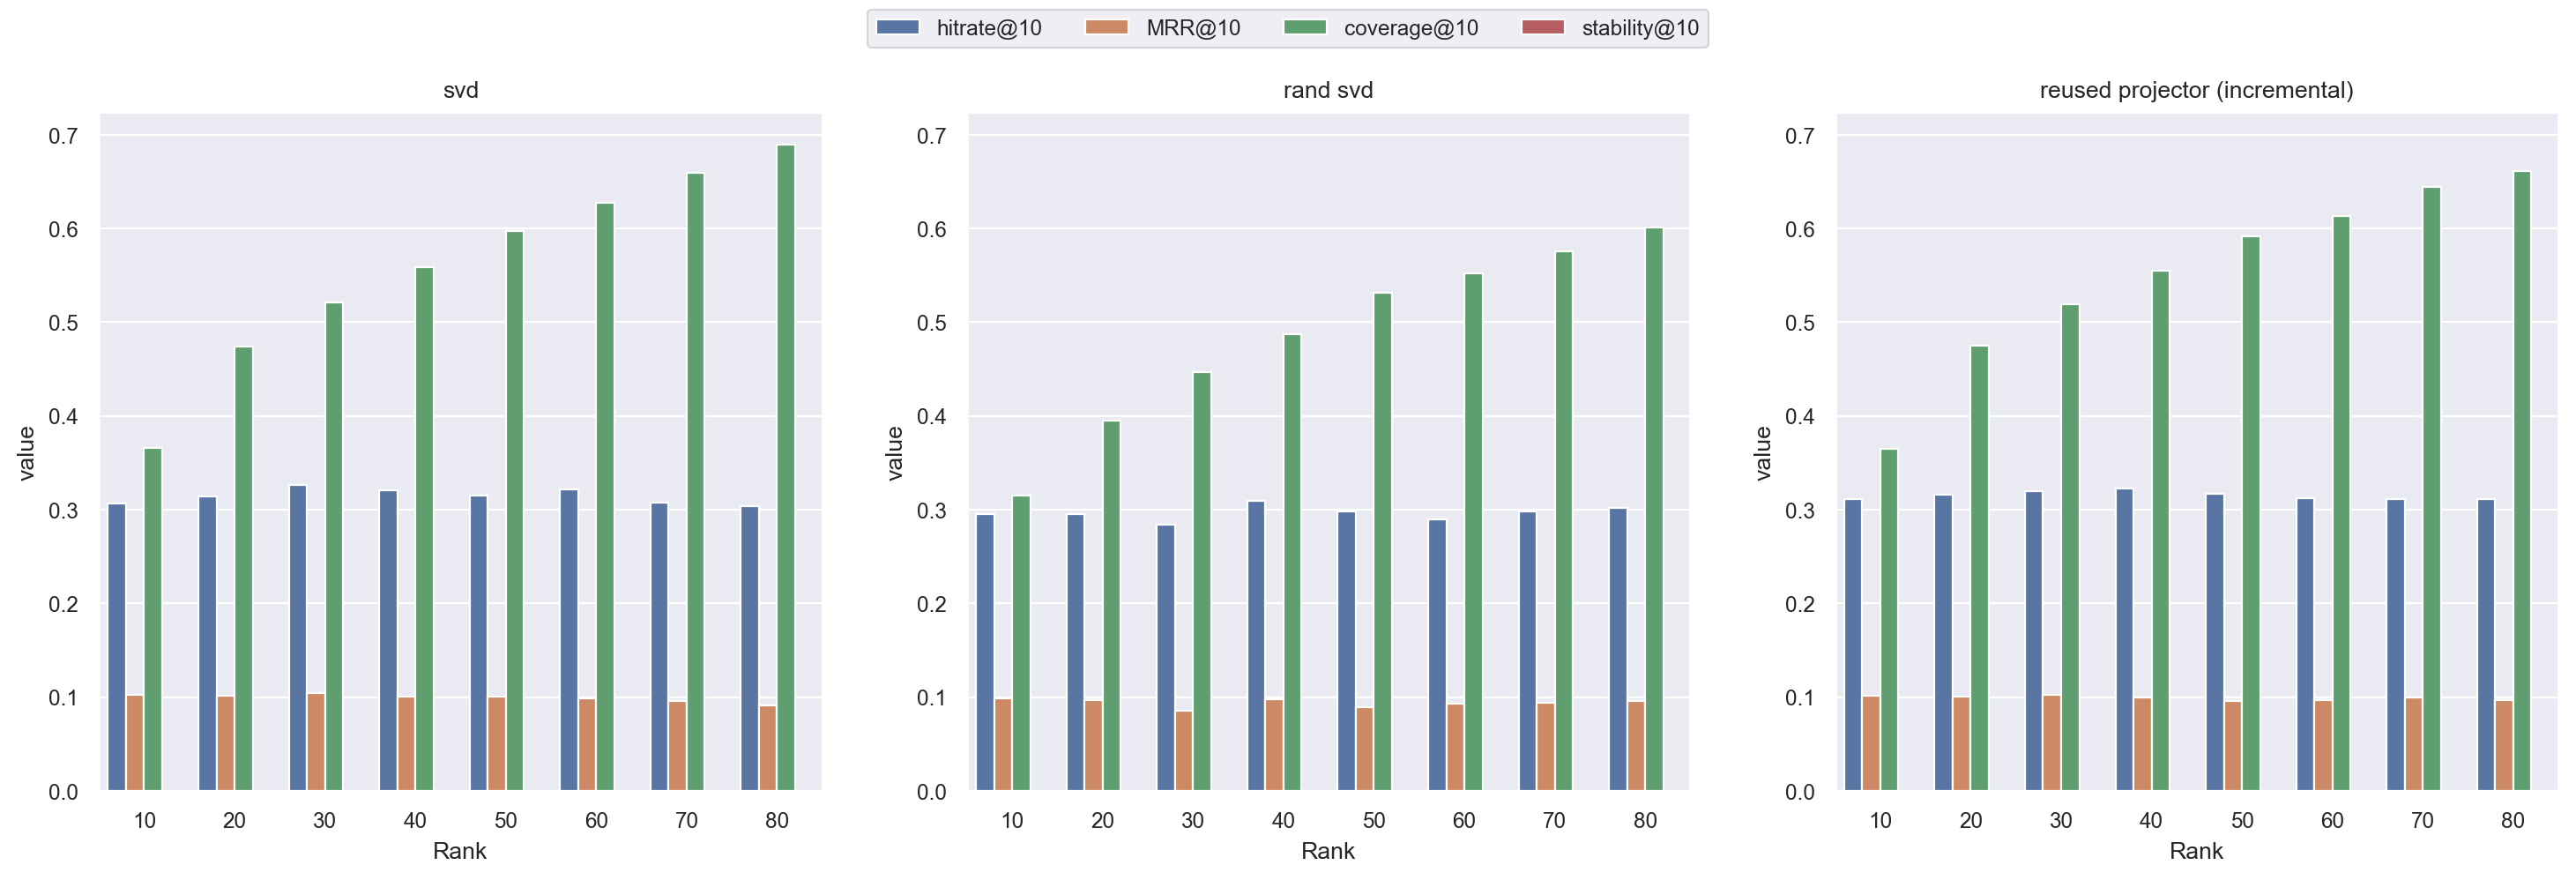

In [48]:
visualize_experiment_rank(experiment_metrics_dict, nostability=True)

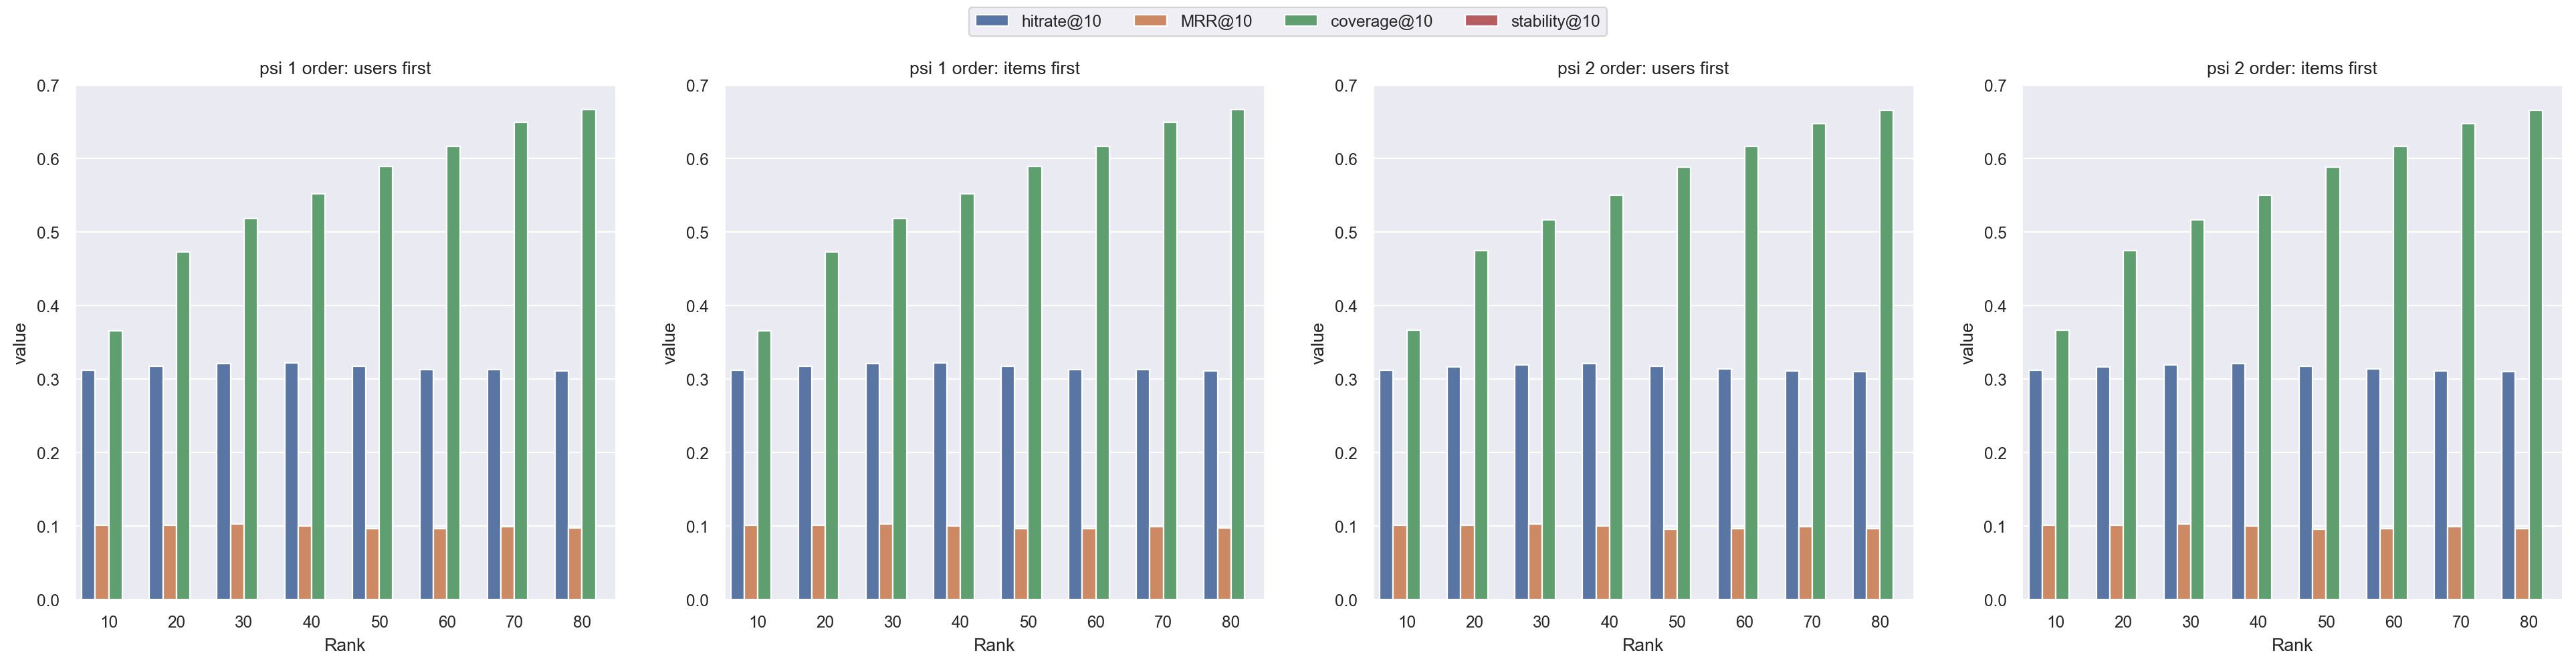

In [49]:
tmp_dict = {}
tmp_dict[f'{PSI1}: {USERS_FIRST}'] = experiment_metrics_dict_psi[PSI1][USERS_FIRST]
tmp_dict[f'{PSI1}: {ITEMS_FIRST}'] = experiment_metrics_dict_psi[PSI1][USERS_FIRST]
tmp_dict[f'{PSI2}: {USERS_FIRST}'] = experiment_metrics_dict_psi[PSI2][USERS_FIRST]
tmp_dict[f'{PSI2}: {ITEMS_FIRST}'] = experiment_metrics_dict_psi[PSI2][USERS_FIRST]
visualize_experiment_rank(tmp_dict, nostability=True)

# Тест

In [52]:
metrics_dict = {}
for alg_name in ALL_ALG_NAMES:

    if alg_name == SVD:
        rank = 70
        update_type = None
    elif alg_name == RAND_SVD:
        rank = 60
        update_type = None
    elif alg_name == REUSED_PROJECTOR_INCREMENTAL:
        rank = 80
        update_type = None
    elif alg_name == PSI1:
        rank = 80
        update_type = USERS_FIRST
    elif alg_name == PSI2:
        rank = 80
        update_type = USERS_FIRST
    else:
        continue

    metrics = metrics_experiment(
        algorithm_name=alg_name,
        rank=rank,
        K=K,
        update_type=update_type,
        training=bigtraindata,
        data=measure_data
    )
    metrics_dict[alg_name] = metrics

reused projector (incremental): 100%|██████████| 6/6 [00:27<00:00,  4.64s/it]


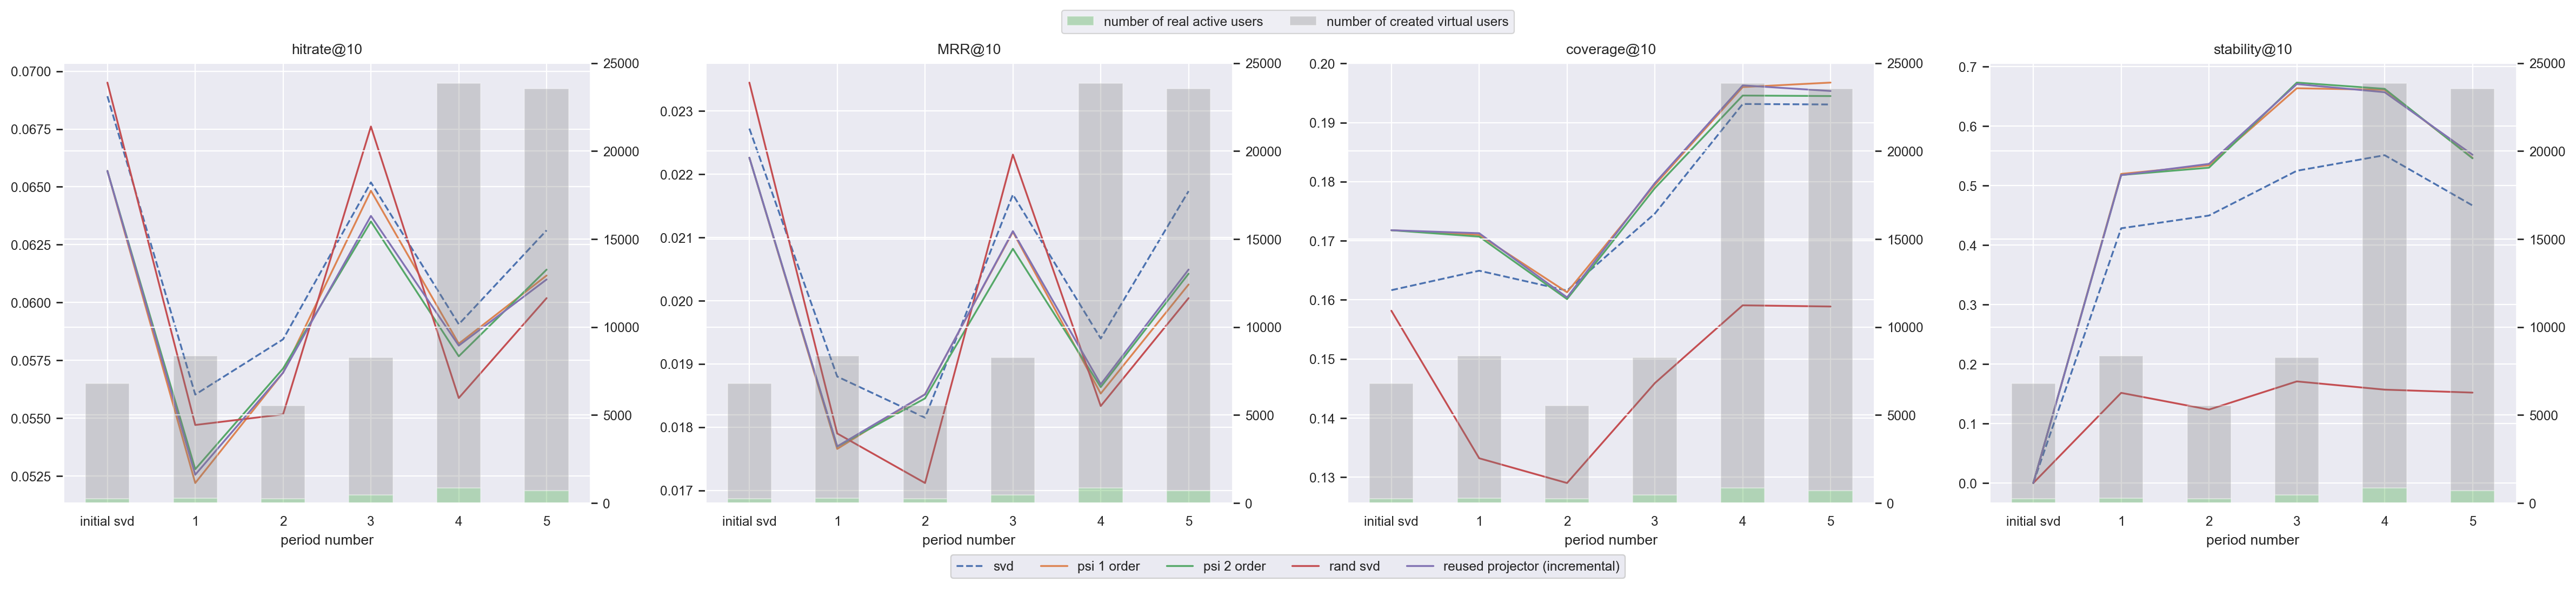

In [55]:
visualize_all(metrics_dict, K, measure_data)

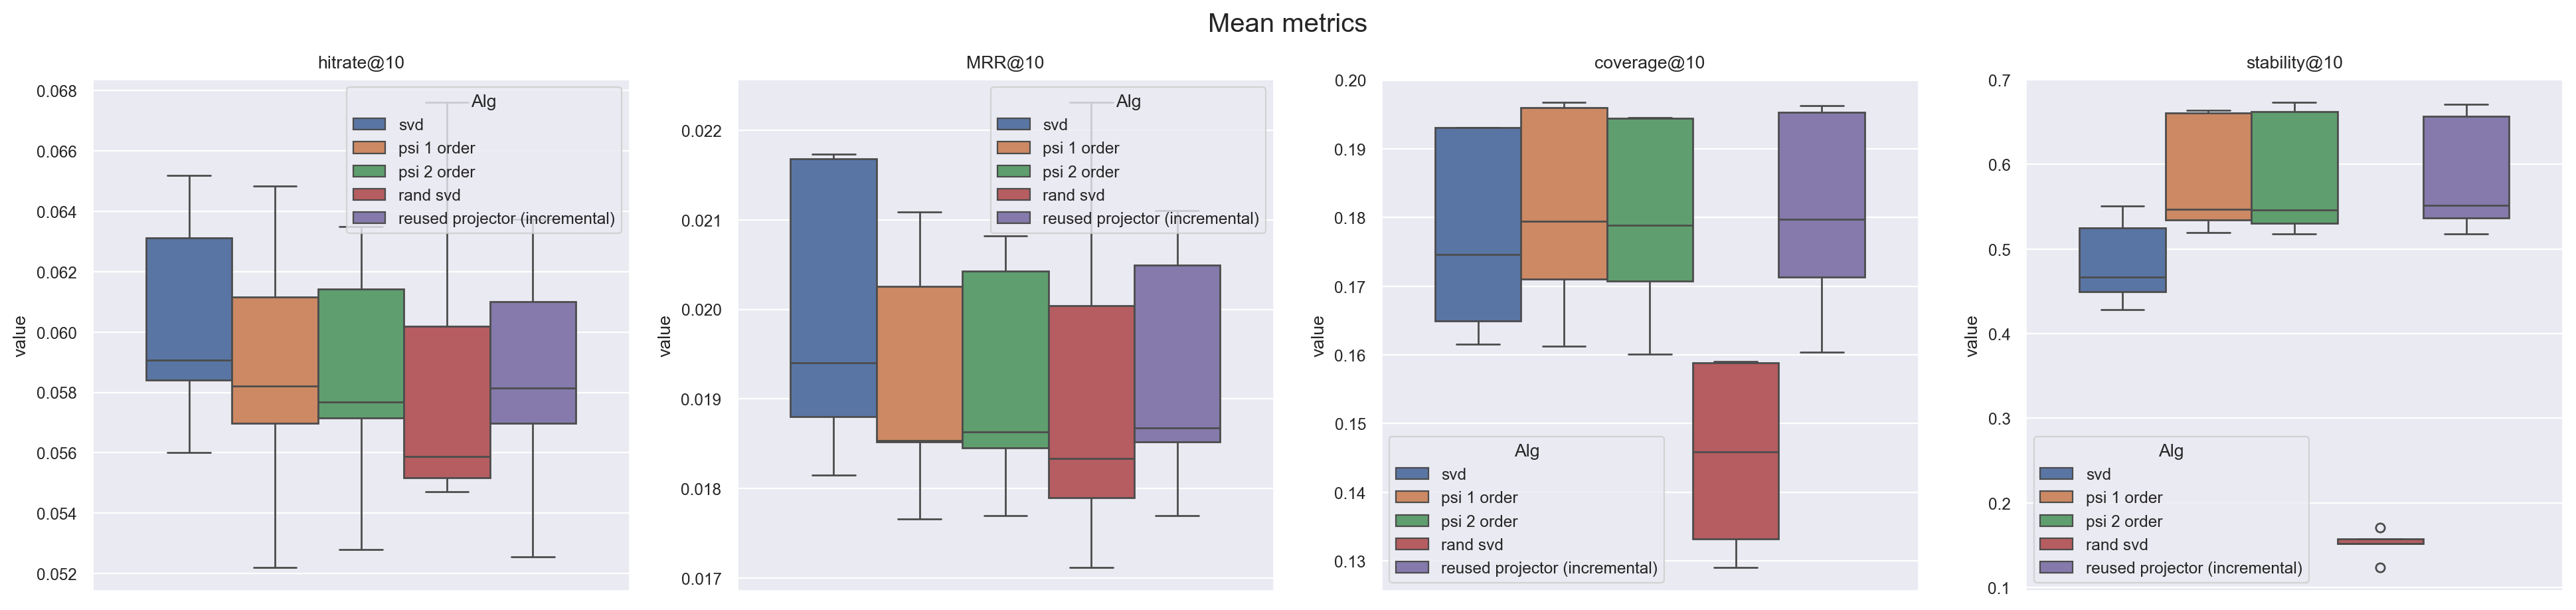

In [73]:

d = {}
d['Rank'] = []
df_big = pd.DataFrame(d)
for alg_name, rank_metrics_dict in metrics_dict.items():
    dfm = pd.DataFrame(
        rank_metrics_dict[0][:, 1:].T, 
        columns=METRICS_NAMES_K(K)).assign(Rank=ranks[0]).assign(Alg=alg_name)
    df_big = pd.concat([df_big, dfm])
mdf = pd.melt(df_big, id_vars=['Alg', 'Rank'], var_name='Metric') 
mdf['Rank'] = mdf['Rank'].astype(int)
fig, ax = plt.subplots(1, N_METRICS, figsize=(6 * N_METRICS, 5))
for i, metric_name in enumerate(METRICS_NAMES_K(K)):
    sns.boxplot(y="value", hue="Alg", 
                data=mdf[mdf['Metric'] == metric_name],
                ax=ax[i])
    ax[i].set_title(metric_name)
fig.suptitle('Mean metrics')
plt.show()

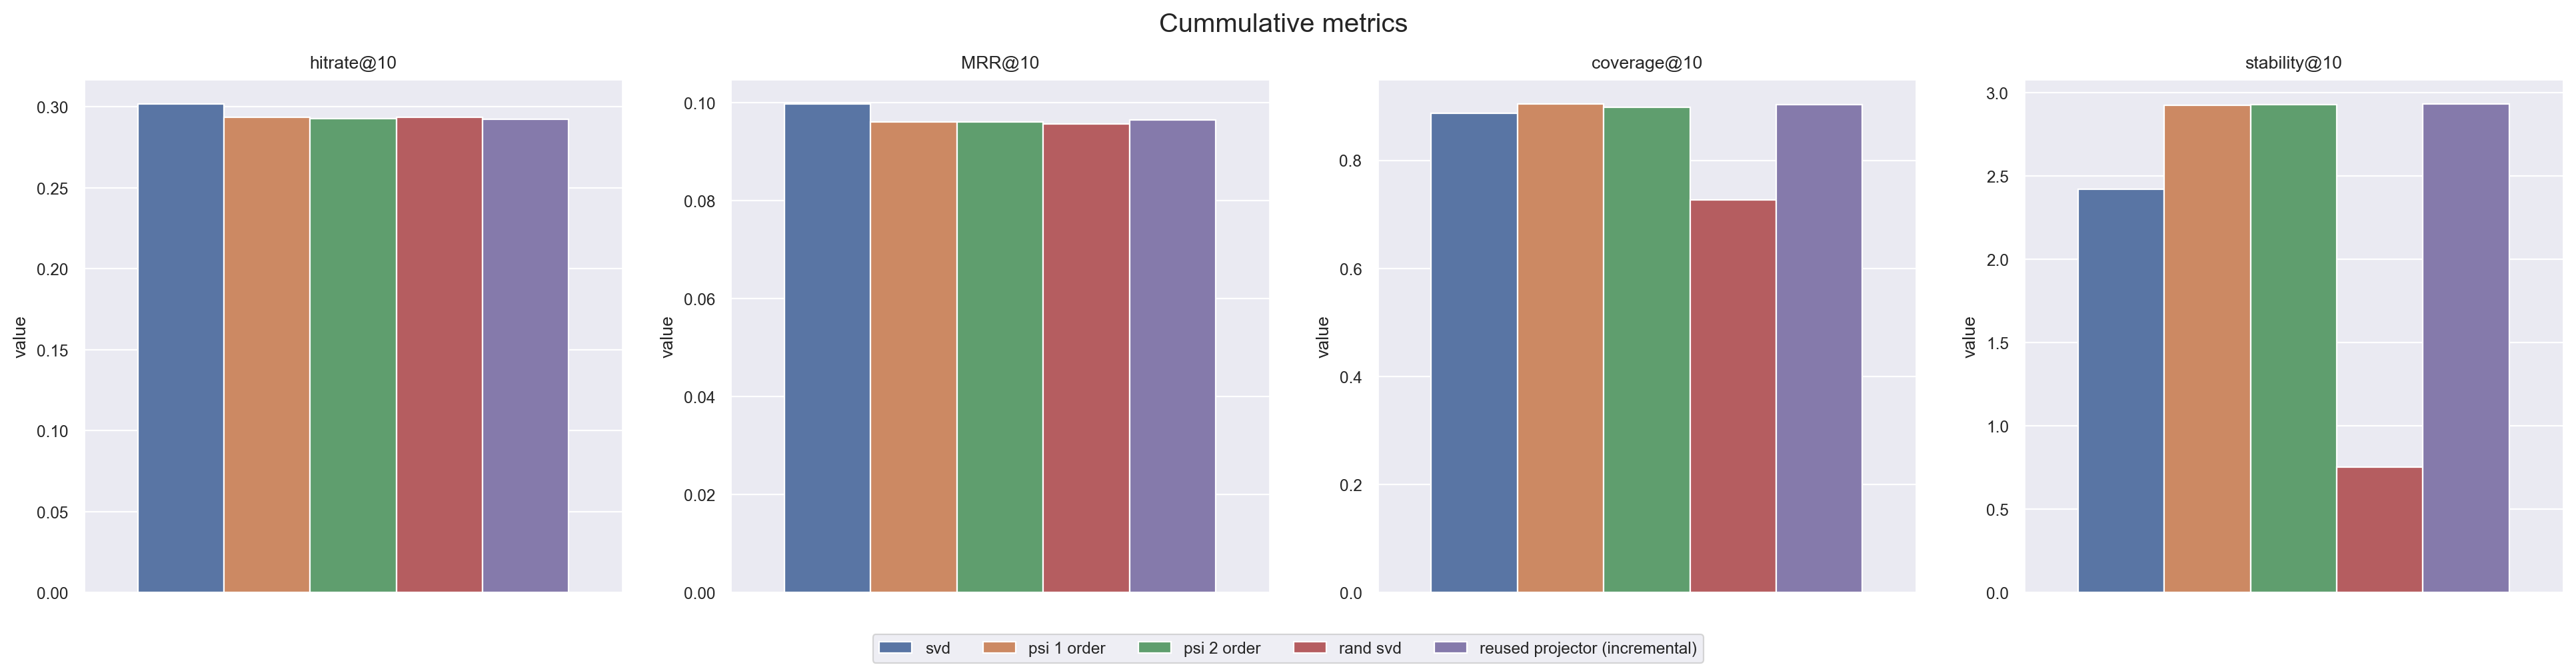

In [74]:
d = {}
d['Rank'] = []
df_big = pd.DataFrame(d)
for alg_name, rank_metrics_dict in metrics_dict.items():
    dfm = pd.DataFrame(
        rank_metrics_dict[0][:, 1:].T, 
        columns=METRICS_NAMES_K(K)).assign(Rank=ranks[0]).assign(Alg=alg_name)
    df_big = pd.concat([df_big, dfm])
mdf = pd.melt(df_big, id_vars=['Alg', 'Rank'], var_name='Metric') 
mdf['Rank'] = mdf['Rank'].astype(int)

gdf = mdf.groupby(['Alg', 'Rank', 'Metric'], as_index=False).sum()
gdf['Alg'] = pd.Categorical(gdf['Alg'], list(metrics_dict.keys()))
gdf = gdf.sort_values("Alg")

fig, ax = plt.subplots(1, N_METRICS, figsize=(6 * N_METRICS, 5))
for i, metric_name in enumerate(METRICS_NAMES_K(K)):
    sns.barplot(y="value", hue="Alg", 
                data=gdf[gdf['Metric'] == metric_name],
                ax=ax[i])
    ax[i].set_title(metric_name)
    legend = ax[i].legend()
    legend.remove()

handles_obj, labels_obj = ax[0].get_legend_handles_labels()
fig.legend(handles_obj, labels_obj, loc='lower center', ncol=len(handles_obj)) #, bbox_to_anchor=(0.5, 1.05))
fig.suptitle('Cummulative metrics')
plt.show()